<h3>Import Libraries</h3>

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


<h3>Configure Device</h3>

In [4]:
# Configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


<h3>Define Data Transformations</h3>

In [4]:
# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),  # Add vertical flip
        transforms.RandomRotation(30),    # Increase rotation
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # Larger scale range
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Add hue
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


<h3>Load Dataset and Create DataFrame</h3>

In [5]:
# Path to dataset
data_dir = "/kaggle/input/dataset1/dataset"

# Create a balanced dataset DataFrame
def create_sample_df(dataset_dir, samples_per_class=100):
    all_data = []
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            image_files = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('png', 'jpg', 'jpeg'))]
            sampled_files = np.random.choice(image_files, samples_per_class, replace=len(image_files) < samples_per_class)
            all_data.extend([(img, class_name) for img in sampled_files])
    return pd.DataFrame(all_data, columns=["image", "label"])

sample_df = create_sample_df(os.path.join(data_dir, 'train'), samples_per_class=500)


<h3>Encode Labels and Split Dataset</h3>

In [6]:
# Encode labels
class_names = sorted(sample_df['label'].unique())
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
sample_df['label_idx'] = sample_df['label'].map(class_to_idx)

# Split into train, validation, and test sets (70/15/15)
train_df, test_val_df = train_test_split(sample_df, test_size=0.3, stratify=sample_df['label_idx'], random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df['label_idx'], random_state=42)


<h3>Custom Dataset and DataLoaders</h3>

In [7]:
# Custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['label_idx']
        image = datasets.folder.default_loader(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label

# Datasets and dataloaders
train_dataset = CustomDataset(train_df, transform=data_transforms['train'])
val_dataset = CustomDataset(val_df, transform=data_transforms['val_test'])
test_dataset = CustomDataset(test_df, transform=data_transforms['val_test'])

dataloaders_dict = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False)
}


<h3>Load Pretrained Model</h3>

In [8]:
# Load a pretrained EfficientNet model
model = models.efficientnet_b4(pretrained=True)
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))  # Number of lesion classes
)

model = model.to(device)
print(model)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 204MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

<h3>Define Loss Function, Optimizer and Scheduler</h3>

In [9]:
# Define loss function with class weights
class_counts = sample_df['label'].value_counts()
class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float32)
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer and scheduler
optimizer = optim.RAdam(model.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.2, verbose=True)


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


<h3>Train the Model</h3>

Epoch 1/60


Train: 100%|██████████| 77/77 [01:12<00:00,  1.06it/s]


Train Loss: 1.9393 Acc: 0.1698


Val: 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]


Val Loss: 1.9250 Acc: 0.2343
Epoch 2/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.27it/s]


Train Loss: 1.8885 Acc: 0.3098


Val: 100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Val Loss: 1.7983 Acc: 0.4724
Epoch 3/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.27it/s]


Train Loss: 1.5737 Acc: 0.4518


Val: 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Val Loss: 1.1622 Acc: 0.5752
Epoch 4/60


Train: 100%|██████████| 77/77 [00:59<00:00,  1.29it/s]


Train Loss: 1.2061 Acc: 0.5510


Val: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Val Loss: 0.9342 Acc: 0.6438
Epoch 5/60


Train: 100%|██████████| 77/77 [00:59<00:00,  1.29it/s]


Train Loss: 1.0229 Acc: 0.6086


Val: 100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Val Loss: 0.8502 Acc: 0.6590
Epoch 6/60


Train: 100%|██████████| 77/77 [00:59<00:00,  1.28it/s]


Train Loss: 0.8780 Acc: 0.6763


Val: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Val Loss: 0.7664 Acc: 0.6952
Epoch 7/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s]


Train Loss: 0.7790 Acc: 0.7045


Val: 100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Val Loss: 0.7243 Acc: 0.7219
Epoch 8/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.27it/s]


Train Loss: 0.6968 Acc: 0.7449


Val: 100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Val Loss: 0.6343 Acc: 0.7524
Epoch 9/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s]


Train Loss: 0.6655 Acc: 0.7547


Val: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Val Loss: 0.6391 Acc: 0.7562
Epoch 10/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s]


Train Loss: 0.5939 Acc: 0.7800


Val: 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Val Loss: 0.5535 Acc: 0.8000
Epoch 11/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s]


Train Loss: 0.5332 Acc: 0.8012


Val: 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Val Loss: 0.5379 Acc: 0.7771
Epoch 12/60


Train: 100%|██████████| 77/77 [00:59<00:00,  1.29it/s]


Train Loss: 0.5044 Acc: 0.8155


Val: 100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Val Loss: 0.5446 Acc: 0.7848
Epoch 13/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s]


Train Loss: 0.4635 Acc: 0.8359


Val: 100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Val Loss: 0.5209 Acc: 0.8171
Epoch 14/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s]


Train Loss: 0.4070 Acc: 0.8502


Val: 100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Val Loss: 0.5186 Acc: 0.8057
Epoch 15/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.27it/s]


Train Loss: 0.3938 Acc: 0.8514


Val: 100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Val Loss: 0.5346 Acc: 0.8076
Epoch 16/60


Train: 100%|██████████| 77/77 [00:59<00:00,  1.28it/s]


Train Loss: 0.3701 Acc: 0.8690


Val: 100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Val Loss: 0.4895 Acc: 0.8190
Epoch 17/60


Train: 100%|██████████| 77/77 [00:59<00:00,  1.29it/s]


Train Loss: 0.3161 Acc: 0.8857


Val: 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Val Loss: 0.5022 Acc: 0.8267
Epoch 18/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s]


Train Loss: 0.3069 Acc: 0.8890


Val: 100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Val Loss: 0.4779 Acc: 0.8248
Epoch 19/60


Train: 100%|██████████| 77/77 [00:59<00:00,  1.29it/s]


Train Loss: 0.2890 Acc: 0.8992


Val: 100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Val Loss: 0.5409 Acc: 0.8229
Epoch 20/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s]


Train Loss: 0.2680 Acc: 0.8992


Val: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Val Loss: 0.5276 Acc: 0.8171
Epoch 21/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.27it/s]


Train Loss: 0.2440 Acc: 0.9086


Val: 100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Val Loss: 0.5395 Acc: 0.8210
Epoch 22/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.27it/s]


Train Loss: 0.2081 Acc: 0.9245


Val: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Val Loss: 0.4993 Acc: 0.8324
Epoch 23/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s]


Train Loss: 0.1918 Acc: 0.9347


Val: 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Val Loss: 0.4902 Acc: 0.8419
Epoch 24/60


Train: 100%|██████████| 77/77 [00:59<00:00,  1.29it/s]


Train Loss: 0.1893 Acc: 0.9339


Val: 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Val Loss: 0.4747 Acc: 0.8457
Epoch 25/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.27it/s]


Train Loss: 0.1749 Acc: 0.9335


Val: 100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Val Loss: 0.4826 Acc: 0.8400
Epoch 26/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.27it/s]


Train Loss: 0.1485 Acc: 0.9453


Val: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Val Loss: 0.5029 Acc: 0.8533
Epoch 27/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.27it/s]


Train Loss: 0.1636 Acc: 0.9424


Val: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Val Loss: 0.5008 Acc: 0.8476
Epoch 28/60


Train: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s]


Train Loss: 0.1617 Acc: 0.9437


Val: 100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Val Loss: 0.4956 Acc: 0.8476
Epoch 29/60


Train: 100%|██████████| 77/77 [00:59<00:00,  1.29it/s]


Train Loss: 0.1602 Acc: 0.9445


Val: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Val Loss: 0.4775 Acc: 0.8476
Epoch 30/60


Train: 100%|██████████| 77/77 [00:59<00:00,  1.29it/s]


Train Loss: 0.1443 Acc: 0.9469


Val: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Val Loss: 0.4845 Acc: 0.8419
Epoch 31/60


Train: 100%|██████████| 77/77 [00:59<00:00,  1.29it/s]


Train Loss: 0.1278 Acc: 0.9580


Val: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Val Loss: 0.4978 Acc: 0.8476
Epoch 32/60


Train: 100%|██████████| 77/77 [00:59<00:00,  1.29it/s]


Train Loss: 0.1509 Acc: 0.9461


Val: 100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Val Loss: 0.4880 Acc: 0.8495
Early stopping triggered.
Best Validation Accuracy: 0.8533


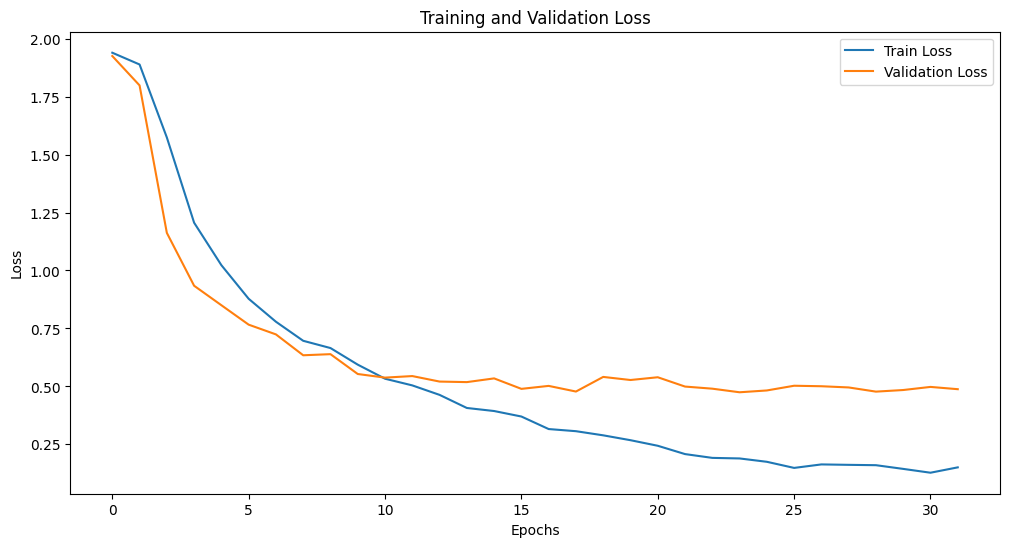

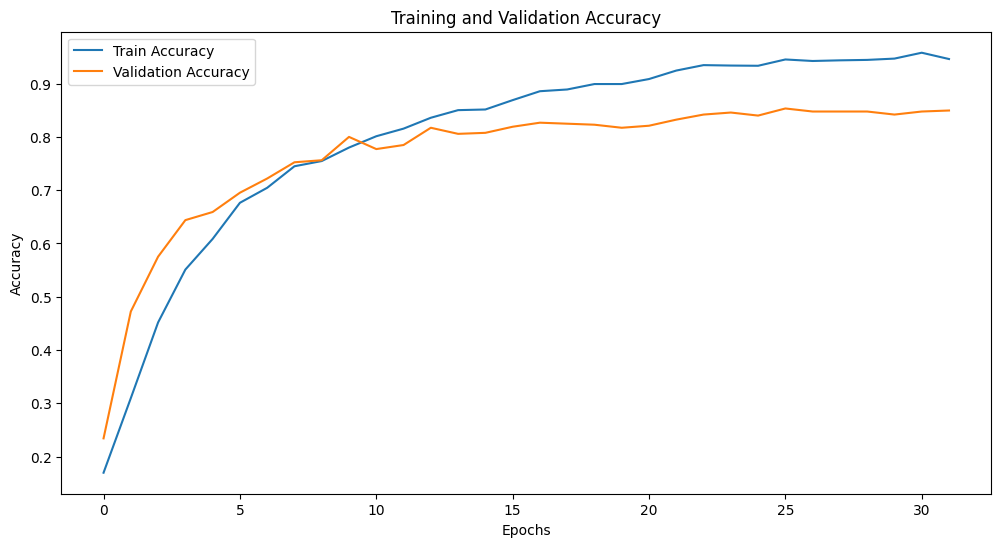

In [10]:
# Training function with fine-tuning and early stopping
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=60, patience=6):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    early_stopping_counter = 0
    train_loss, train_acc, val_loss, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase.capitalize()}"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.item())
            elif phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.item())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val':
                scheduler.step(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Best Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)

    # Plot loss and accuracy trends
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")
    plt.show()

    return model

# Train the model
model = train_model(model, dataloaders_dict, criterion, optimizer, scheduler)


<h3>Evaluate Model (Confusion Matrix)</h3>

Evaluating: 100%|██████████| 17/17 [00:07<00:00,  2.24it/s]


Classification Report:
              precision    recall  f1-score   support

       akiec       0.93      0.85      0.89        75
         bcc       0.90      0.85      0.88        75
         bkl       0.68      0.79      0.73        75
          df       0.96      1.00      0.98        75
         mel       0.78      0.75      0.76        75
          nv       0.86      0.83      0.84        75
        vasc       0.99      1.00      0.99        75

    accuracy                           0.87       525
   macro avg       0.87      0.87      0.87       525
weighted avg       0.87      0.87      0.87       525



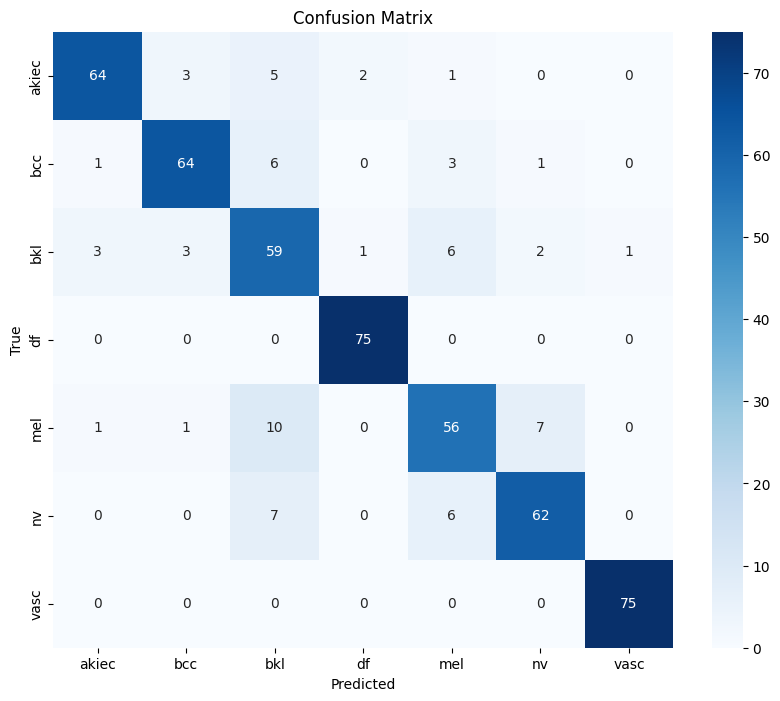

In [11]:
# Evaluate model on test set
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return all_labels, all_preds

# Call the evaluation function
test_labels, test_preds = evaluate_model(model, dataloaders_dict['test'], class_names)


<h3>Plot ROC Curve</h3>

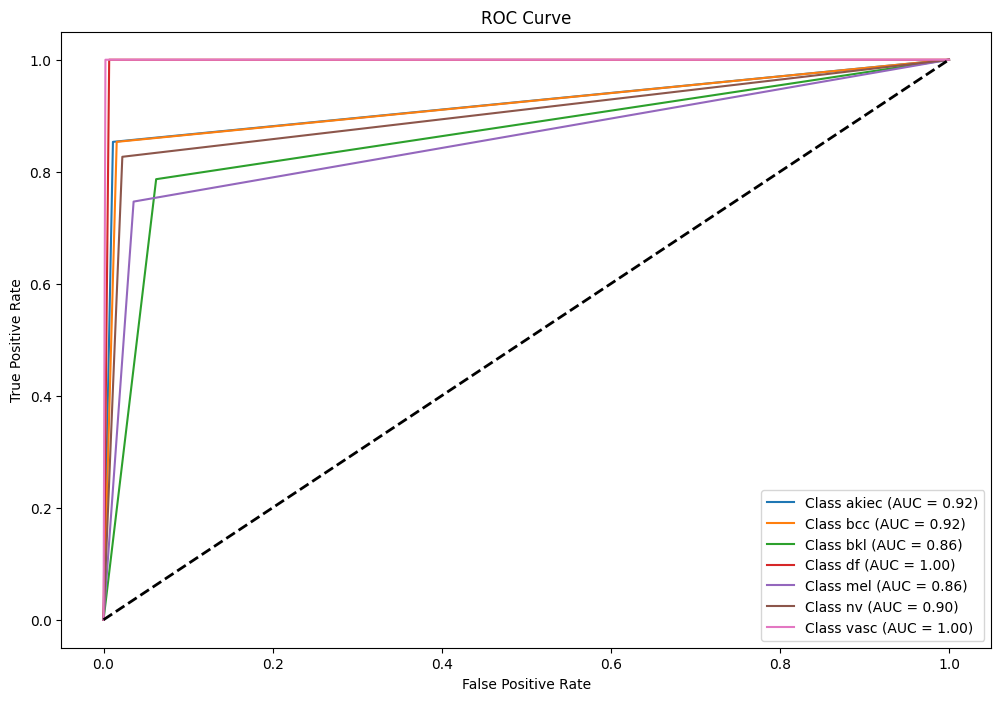

In [12]:
# Generate ROC curve
def plot_roc_curve(labels, preds, class_names):
    labels_bin = label_binarize(labels, classes=range(len(class_names)))
    preds_bin = label_binarize(preds, classes=range(len(class_names)))

    n_classes = len(class_names)
    plt.figure(figsize=(12, 8))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_bin[:, i], preds_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.show()

# Call ROC curve plot
plot_roc_curve(test_labels, test_preds, class_names)


<h3>Save the model</h3>

In [13]:
# Save the entire trained model
torch.save(model, 'final_skin_lesion_detection_model2.pth')
